In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

NUM_CLASSES = 102
NUM_IMAGES_PER_CLASS = 5

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [5]:
# subset of the training dataset with only a few images per class
labels = np.array(train_dataset._labels)
selected_indices = []

for class_id in range(NUM_CLASSES):
    # Find indices of samples that belong to the current class
    class_indices = np.where(labels == class_id)[0]
    # Randomly select NUM_IMAGES_PER_CLASS indices from the current class
    random_class_indices = np.random.choice(class_indices, NUM_IMAGES_PER_CLASS, replace=False)
    selected_indices.extend(random_class_indices)

few_shot_subset = Subset(train_dataset, selected_indices)

In [6]:
train_loader = DataLoader(few_shot_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)

if torch.cuda.is_available():
    model = model.cuda()

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
class EarlyStopper:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = float('inf')
        self.verbose = verbose

    def early_stop(self, val_loss, model):
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'few_shot_model.pth')
        else:
            self.counter += 1
           
        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")
            return True
        return False

In [9]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
earlystopper = EarlyStopper()

In [11]:
accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES).to(device)

In [12]:

# Training function
def train_model(model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100):
    train_losses_history = []
    val_losses_history = []
    train_accuracies_history = []
    val_accuracies_history = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            correct += accuracy(outputs, labels).item()
            total += 1
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        

        average_train_loss = running_loss / total
        average_train_accuracy = correct / total
        train_losses_history.append(average_train_loss)
        train_accuracies_history.append(average_train_accuracy)

        
       # Validation
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        running_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += accuracy(outputs, labels).item()
                total += 1

        average_val_loss = running_loss / total
        average_val_accuracy = correct / total
        val_losses_history.append(average_val_loss)
        val_accuracies_history.append(average_val_accuracy)

        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")

        if earlystopper.early_stop(average_val_loss, model):
            break 
    
    return train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history



In [13]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100
)

Epoch [0/100], Train Loss: 4.3041, Train Accuracy: 0.0913, Validation Loss: 6.2188, Validation Accuracy: 0.0395
Epoch [1/100], Train Loss: 1.8191, Train Accuracy: 0.5731, Validation Loss: 2.2715, Validation Accuracy: 0.1746
Epoch [2/100], Train Loss: 0.5509, Train Accuracy: 0.9347, Validation Loss: 1.6626, Validation Accuracy: 0.2615
Epoch [3/100], Train Loss: 0.1874, Train Accuracy: 0.9852, Validation Loss: 1.3616, Validation Accuracy: 0.2942
Epoch [4/100], Train Loss: 0.0594, Train Accuracy: 1.0000, Validation Loss: 1.2498, Validation Accuracy: 0.3364
Epoch [5/100], Train Loss: 0.0228, Train Accuracy: 1.0000, Validation Loss: 1.1280, Validation Accuracy: 0.3601
Epoch [6/100], Train Loss: 0.0107, Train Accuracy: 1.0000, Validation Loss: 1.0464, Validation Accuracy: 0.3924
Epoch [7/100], Train Loss: 0.0079, Train Accuracy: 1.0000, Validation Loss: 1.0143, Validation Accuracy: 0.4100
Epoch [8/100], Train Loss: 0.0054, Train Accuracy: 1.0000, Validation Loss: 0.9971, Validation Accuracy:

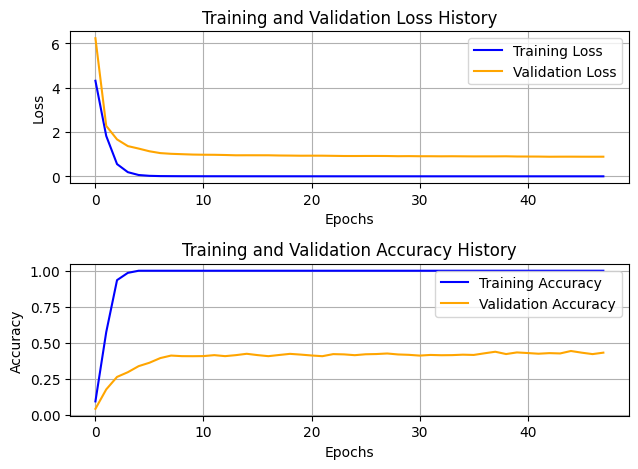

In [14]:
def plot_loss_and_accuracy(train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(train_losses_history, label='Training Loss', color='blue')
    ax1.plot(val_losses_history, label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(train_accuracies_history, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies_history, label='Validation Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout() 
    plt.show()

    
plot_loss_and_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

In [15]:
m = models.resnet18(pretrained=False)  # Set pretrained=True if needed
m.fc = torch.nn.Linear(m.fc.in_features, 102)
m.load_state_dict(torch.load('few_shot_model.pth'))
m.eval()
if torch.cuda.is_available():
    m = m.to('cuda')
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                images, labels = images.to('cuda'), labels.to('cuda')
                
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            
            total += labels.size(0)  # Increment total count
            correct += (predicted == labels).sum().item()  # Increment correct predictions
    
    accuracy = correct / total  # Calculate accuracy
    return accuracy

# Call the evaluation function
accuracy = evaluate_model(m, test_loader)


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Wt200\AppData\Local\Temp\ipykernel_15240\3268210794.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

In [16]:
accuracy

0.7528053342006831